##  **Extracting and Analyzing E-Commerce Product Data**

> **Name**: Raúl 

> **Last Name**: Varela Ferrando

> **E-mail**: raulvarela97@gmail.com

In [3]:
# Setup
!!pip install BeautifulSoup4 pandas plotly requests tweepy hug fastapi scikit-image
import json
import re
import pandas as pd
import plotly.express as px
import requests
import tweepy
from bs4 import BeautifulSoup

<div style="font-size: 1em; margin: 1em 0 1em 0; border: 1px solid #86989B; background-color: #f7f7f7; padding: 0;">
<p style="margin: 0; padding: 0.1em 0 0.1em 0.5em; color: white; border-bottom: 1px solid #86989B; font-weight: bold; background-color: #AFC1C4;">
Exercise 1
</p>
<p style="margin: 0.5em 1em 0.5em 1em; padding: 0;">
Using the website https://webscraper.io/test-sites/e-commerce/allinone, and applying scraping techniques and regular expressions, create a DataFrame, `products`, with the products listed. The DataFrame should have the following columns:
    
  - `device` (`str`), which should be `"laptop"`, `"tablet"`, or `"phone"` (`"phone"` refers to *touch*).
  - `name` (`str`), the name of the device.
  - `price` (`float`), the price in euros ($1 ~ 0.90€)
  - `screen` (`float`), the screen size in inches of the device
  - `stars` (`int`), the number of stars
  - `reviews` (`int`), the number of reviews

Additionally, return:
1. The average price per device
2. The name of the most expensive product per device
3. The screen size of the highest-rated product with at least 10 reviews, per device.
</p>
</div>


In [ ]:
urls = {
    "laptop": "https://webscraper.io/test-sites/e-commerce/allinone/computers/laptops",
    "tablet": "https://webscraper.io/test-sites/e-commerce/allinone/computers/tablets",
    "phone": "https://webscraper.io/test-sites/e-commerce/allinone/phones/touch",
}
# Write your solution here
rows = []
us_to_eur = 0.9
screen_re = re.compile(r'\d+.\d*"')
for device, url in urls.items():
    # Send a GET request to the URL
    # And construct a BeautifulSoup object
    downloaded_text = requests.get(url).text
    html = BeautifulSoup(downloaded_text)
    
    # Iterate over the elements of each product
    for div in html.select('body > div.wrapper > div.container.test-site > div > div.col-md-9 > div > div.col-sm-4.col-lg-4.col-md-4'):
         # Extract the price in dollars and convert it to euros
        stringprice = div.find('h4').text  # Get the price in dollars (string)
        price_dollar = float(re.search(r'\d+.?\d', stringprice).group())
        price = round(price_dollar * us_to_eur, 2)

        # Extract the product name and description
        name = div.find('a').get('title')  # Get the product names
        
        descrip = div.find('p').text # Get the descriptions
        
        # Count the number of reviews and stars
        RevStars = div.find_all('p') # Create a list with all the p elements
        # By inspecting it, we can see that the reviews correspond to the sublist at index 1 
        # and the stars to the sublist at index 2.
        # Reviews
        stringreviews = RevStars[1].text
        reviews = int(re.search(r'\d*',stringreviews).group())
        
        # Stars
        stars = int(RevStars[2].get('data-rating'))
 
        # Search for the screen size in inches in the description using the regular expression
        match = screen_re.search(descrip)
        if match:
            screen = float(re.search(r'[\d.\d]+', match.group()).group())
        else:
            screen = None
        rows.append((device, name, price, screen, stars, reviews))
products = pd.DataFrame(rows, columns=["device", "name", "price", "screen", "stars", "reviews"])
products

,device,name,price,screen,stars,reviews
0,laptop,Asus VivoBook X441NA-GA190,266.31,14.0,3,14
1,laptop,Prestigio SmartBook 133S Dark Grey,269.10,13.3,2,8
2,laptop,Prestigio SmartBook 133S Gold,269.10,13.3,4,12
3,laptop,Aspire E1-510,276.21,15.6,3,2
4,laptop,Lenovo V110-15IAP,289.71,15.6,3,5
...,...,...,...,...,...,...
142,phone,Sony Xperia,107.01,NaN,1,6
143,phone,Ubuntu Edge,449.91,NaN,1,2
144,phone,Iphone,809.91,NaN,1,10
145,phone,Iphone,809.91,NaN,2,8


In [ ]:
# Average price per device

meanprice = pd.DataFrame(products.groupby('device').mean('price')['price'])
meanprice

,price
device,
laptop,818.418462
phone,360.510000
tablet,208.752857


<table border="1" class="dataframe" style="margin-left: 0;">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>price</th>
    </tr>
    <tr>
      <th>device</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>laptop</th>
      <td>818.454462</td>
    </tr>
    <tr>
      <th>phone</th>
      <td>360.591000</td>
    </tr>
    <tr>
      <th>tablet</th>
      <td>208.833857</td>
    </tr>
  </tbody>
</table>

In [ ]:
# The name of the most expensive product per device.

result = []
for device in urls.keys():
    # Split our 'products' DataFrame into 3 based on the 'device' column
    split_products = products[products['device'] == device]
    # For each of the 3 DataFrames, find the one with the maximum price and drop the columns we don't need.
    max_products = products[products['price'] == split_products['price'].max()].drop(['price', 'screen', 'stars', 'reviews'], axis=1)
    # Save the most expensive product for each device type. At this step, iPhone is saved 3 times, which I couldn't
    # solve in any other way than removing the duplicate rows in the next step.
    result.append(max_products)

result = pd.concat(result)[:3].set_index('device')
result

,name
device,
laptop,Asus ROG Strix SCAR Edition GL503VM-ED115T
tablet,Apple iPad Air
phone,Iphone


<table border="1" class="dataframe" style="margin-left: 0;">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>name</th>
    </tr>
    <tr>
      <th>device</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>laptop</th>
      <td>Asus ROG Strix SCAR Edition GL503VM-ED115T</td>
    </tr>
    <tr>
      <th>phone</th>
      <td>Iphone</td>
    </tr>
    <tr>
      <th>tablet</th>
      <td>Apple iPad Air</td>
    </tr>
  </tbody>
</table>

In [ ]:
# The largest screen size among the products with at least 10 reviews, per device

maxscreen = pd.DataFrame(products[products['reviews'] >= 10].groupby('device')['screen'].max())
maxscreen

,screen
device,
laptop,17.3
phone,3.2
tablet,10.1


<table border="1" class="dataframe" style="margin-left: 0;">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>screen</th>
    </tr>
    <tr>
      <th>device</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>laptop</th>
      <td>17.3</td>
    </tr>
    <tr>
      <th>phone</th>
      <td>3.2</td>
    </tr>
    <tr>
      <th>tablet</th>
      <td>10.1</td>
    </tr>
  </tbody>
</table>

<div style="font-size: 1em; margin: 1em 0 1em 0; border: 1px solid #86989B; background-color: #f7f7f7; padding: 0;">
<p style="margin: 0; padding: 0.1em 0 0.1em 0.5em; color: white; border-bottom: 1px solid #86989B; font-weight: bold; background-color: #AFC1C4;">
Exercise 2
</p>
<p style="margin: 0.5em 1em 0.5em 1em; padding: 0;">
You are asked to build a function, <code>geo_coords()</code>, that receives a search term and an integer indicating how many times the search should be performed. We only want tweets in Spanish.

For each tweet returned, you must extract the names of the cities and also their geographic coordinates. The function’s output should be a deduplicated DataFrame with the cleaned name of the mentioned city, the latitude, the longitude, and the number of mentions.

To obtain the list of places from a text, you should create a function <code>get_placenames()</code> that receives a text string and returns a list of the places mentioned. You can use the API from <a href="http://text-processing.com/docs/phrases.html">text-processing.com</a> or the test version of <a href="https://explosion.ai/demos/displacy-ent">spaCy</a>. To obtain the geographic coordinates from the name of a place (geocoding), you can use the API from <a href="https://nominatim.openstreetmap.org/">OpenStreetMaps</a> or that of <a href="https://geocode.xyz">geocode.xyz</a> (for example, coordinates for Kinshasa: <a href="https://geocode.xyz/Kinsasa?json=1">https://geocode.xyz/Kinsasa?json=1</a>).

You can use the credentials provided in class to connect to Twitter using <code>tweepy</code>, or you can obtain your own personal credentials.

(<b>Note:</b> Both the place detector and the coordinate finder might not be precise enough, so we may encounter errors, such as non-place entities being identified as places, and coordinates that do not correspond to the expected locations. For this exercise, we will ignore those kinds of errors.)
</p>
</div>

In [ ]:
# Write your solution here
# Twitter credentials
CONSUMER_KEY = "eN8Ntpf0nTUEABOArdKPqUoE0"
CONSUMER_SECRET = "PNkspq4Q61gcs3nOGlzv8fgphLMQREetkBET9oZZ2kuspT3Pek"
ACCESS_TOKEN_KEY = "3365101-h8FehpaZcN7LB9xwtG9FOZGJIEi7Ik0fyvaVM6Dr4B"
ACCESS_TOKEN_SECRET = "dalc8Idah3nvUDcPeCoFXmHccTxPnjmnjvNOs35O31w0E"


def get_placenames(text):
    """Extracts a list of places (those tagged as LOC)
    using the spaCy demo API. If no place is found,
    it should return an empty list.
    For example:
        get_placenames("Vivo en España") == ["España"]
    """
    headers = {'Content-Type': 'application/json'}
    data = {"text": text, "model": "es_core_news_sm"}
    response = requests.post(
        'https://displacy.prod.demos.explosion.services/ent',
        headers=headers,
        data=json.dumps(data)
    )
    place_list = []
    
    if response.status_code == 200:
        json_response = response.json()
        for element in json_response:
            if element.get('label') == 'LOC':
                start = element.get('start')
                end = element.get('end')
                place = text[start:end]
                place_list.append(place)
        return place_list
    else:
        return place_list


def get_latlon(placename):
    """Extracts the latitude and longitude (as floats) for a place with the given name.
    If not found, it should return the tuple (None, None).
    For example:
        get_latlon("España") == (39.3262345, -4.8380649)
    """
    response = requests.get(
        f'https://nominatim.openstreetmap.org/search?q={placename}&limit=1&format=json'
    )
    if response.status_code == 200:
        json_response = response.json()
        if json_response:
            lat = float(json_response[0].get('lat'))
            lon = float(json_response[0].get('lon'))
            return lat, lon
    else:
        return None, None


def get_coords(search, iterations=1):
    # Authenticate with Twitter using tweepy
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN_KEY, ACCESS_TOKEN_SECRET)
    api = tweepy.API(auth)
    maxcount = 10
    rows = []
    
    for _ in range(iterations):
        results = api.search_tweets(q=search, count=maxcount, lang='es')
        count = 0
        for status in results:
            count += 1
            text = status.text
            placenames = get_placenames(text)
            
            for placename in placenames:
                lat, lon = get_latlon(placename)
                if lat and lon:
                    rows.append([placename, lat, lon, count])
    
    df = pd.DataFrame()
    df = df.append(rows)
    df.columns = ['city', 'latitude', 'longitude', 'count']
    return df

coords = get_coords('España')
coords

C:\Users\raulv\AppData\Local\Temp\ipykernel_20316\39984467.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,city,latitude,longitude,count
0,Francia,46.603354,1.888334,3
1,Barcelona,41.382894,2.177432,4
2,Gobierno de España,42.815898,-1.642760,7
3,México,23.658512,-102.007710,10
4,EU,50.049170,1.417574,10
5,Brasil,-10.333333,-53.200000,10


<table border="1" class="dataframe" style="margin-left: 0;">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>city</th>
      <th>latitude</th>
      <th>longitude</th>
      <th>count</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Almeria</td>
      <td>36.85574</td>
      <td>-2.43543</td>
      <td>4</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Cabo De Palos</td>
      <td>37.63147</td>
      <td>-0.70486</td>
      <td>4</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Hub</td>
      <td>34.50607</td>
      <td>-102.69371</td>
      <td>3</td>
    </tr>
    <tr>
      <th>3</th>
      <td>Lana</td>
      <td>46.60197</td>
      <td>11.13628</td>
      <td>2</td>
    </tr>
    <tr>
      <th>4</th>
      <td>Madrid</td>
      <td>40.42953</td>
      <td>-3.67932</td>
      <td>2</td>
    </tr>
    <tr>
      <th>5</th>
      <td>Marbella</td>
      <td>36.51455</td>
      <td>-4.88741</td>
      <td>4</td>
    </tr>
    <tr>
      <th>6</th>
      <td>Murcia</td>
      <td>37.97627</td>
      <td>-1.12174</td>
      <td>4</td>
    </tr>
    <tr>
      <th>7</th>
      <td>México</td>
      <td>19.44507</td>
      <td>-99.18748</td>
      <td>2</td>
    </tr>
    <tr>
      <th>8</th>
      <td>Sevilla</td>
      <td>37.46106</td>
      <td>-6.01314</td>
      <td>4</td>
    </tr>
    <tr>
      <th>9</th>
      <td>Valle</td>
      <td>58.92373</td>
      <td>9.56399</td>
      <td>2</td>
    </tr>
  </tbody>
</table>
(This result is indicative; each execution of the Twitter API search will return different results, and therefore different cities.).

If everything went well, you should be able to view the `DataFrame coords` by running the following cell.

In [111]:
px.scatter_geo(coords, lat="latitude", lon="longitude", text="city", size="count")

<div style="font-size: 1em; margin: 1em 0 1em 0; border: 1px solid #86989B; background-color: #f7f7f7; padding: 0;">
<p style="margin: 0; padding: 0.1em 0 0.1em 0.5em; color: white; border-bottom: 1px solid #86989B; font-weight: bold; background-color: #AFC1C4;">
Exercise 3 (optional, only counts if any of the previous ones are left undone or incorrect)
</p>
<p style="margin: 0.5em 1em 0.5em 1em; padding: 0;">
The task is to create a REST API for the website https://elpais.com/, with one endpoint for each main section. Each of these endpoints should return a list of the news it contains, with each news item including the title, summary, and author (if available). The endpoints to create are:

  - `/`, front page news.
  - `/internacional`, international news.
  - `/opinion`, opinion news.
  - `/politica`, news from Spain.
  - `/sociedad`, society news.
  - `/economia`, economic news.
  - `/ciencia`, science news.
  - `/tecnologia`, technology news.
  - `/cultura`, culture news.
  - `/gente`, people news.
  - `/deportes`, sports news.

Additionally, all endpoints may receive up to 2 optional GET parameters:

  - `search` (`str`), so that if specified, only news whose title contains the provided pattern is returned. For example, `/internacional/?search=Germany` should return only the news whose title contains the word `Germany`. The search should be case-insensitive.
  - `limit` (`int`), so that when specified, only the number of news items indicated are returned. For example, `/deportes/?limit=5` should return only the first 5 news items from the sports section.
</p>
    
Code reuse will be valued.
</div>


In [ ]:
url='https://elpais.com/'
downloaded_text = requests.get(url).text
html = BeautifulSoup(downloaded_text)

noticias = html.select('div.z.z-hi > section')

In [ ]:
#%%writefile api.py
# Write (or paste) your solution here

# Header news:
url='https://elpais.com/'
downloaded_text = requests.get(url).text
html = BeautifulSoup(downloaded_text)

titulos = []
resumenes = []
autores = []

title_lines = html.select('.c_t')
resumen_lines = html.select('.c_d')
autor_lines = html.select('.c_a')

for line in title_lines:
    title = line.find('a').text
    titulos.append(title)

for line in resumen_lines:
    resumen = line.text
    resumenes.append(resumen)

for line in autor_lines:
    autor = line.find('a')
    autores.append(autor)


print(autores)

NameError: name 'requests' is not defined

After writing the solution to the exercise and saving it in a file named api.py, you can start a test server in a terminal to see the results.

With FastAPI:

- `uvicorn api:app --reload`

With hug:

- `hug -f api.py`

In any case, some examples of requests and responses are shown below. Note that the returned values will change depending on the date the requests are made, as the pages on elpais.com change daily and sometimes even hourly.

- http://127.0.0.1:8000/
```json
[
    {
        "title":"El PSOE se reúne con los nacionalistas en busca de más apoyos a su coalición con Podemos",
        "author":"José Marcos",
        "summary":""
    },
    {
        "title":"Oriol Junqueras aspira a que la justicia europea obligue al Supremo a excarcelarle",
        "author":"Reyes Rincón",
        "summary":""
    },
    ...
]
```

- http://127.0.0.1:8000/?search=junqueras
```json
[
    {
        "title":"Oriol Junqueras aspira a que la justicia europea obligue al Supremo a excarcelarle",
        "author":"Reyes Rincón",
        "summary":""
    }
]
```

- http://127.0.0.1:8000/cultura/?search=scorsese
```json
[
    {
        "title":"Scorsese",
        "author":"Manuel Vilas",
        "summary":"'El irlandés' tiene que ver más con William Shakespeare que con Hollywood"
    }
]
```

- http://127.0.0.1:8000/television/?limit=2&search=series
```json
[
    {
        "title":"Las 11 series más destacadas de diciembre",
        "author":"Natalia Marcos",
        "summary":""
    },
    {
        "title":"Las series de Apple TV+, de peor a mejor",
        "author":"Natalia Marcos",
        "summary":"Desde tribus que luchan a ciegas hasta una Emily Dickinson que perrea. Así son las ficciones de la nueva plataforma"
    }
]
```

- http://127.0.0.1:8000/deportes/?search=madrid
```json
[
    {
        "title":"Barcelona, Real Madrid y los árbitros, en el mismo hotel",
        "author":"Rebeca Carranco",
        "summary":"La policía extrema la seguridad de cara al clásico del miércoles en el Camp Nou ante la convocatoria de manifestaciones"
    },
    {
        "title":"Guardiola, en el camino del Madrid",
        "author":"David Álvarez",
        "summary":"El City, a 14 puntos del Liverpool en la Premier, se enfrenta al equipo de Zidane, en pleno despegue"
    }
]
```

- http://127.0.0.1:8000/economia/?limit=3
```json
[
    {
        "title":"Boeing suspenderá la producción del 737 MAX, implicado en dos accidentes",
        "author":"Sandro Pozzi",
        "summary":"La empresa vive su mayor crisis tras los siniestros que le costaron la vida a más de 300 personas"
    },
    {
        "title":"El Banco de España cree que el Gobierno no logrará este año reducir el déficit público",
        "author":"Antonio Maqueda",
        "summary":"El organismo supervisor ve indicios de estabilización en la economía española"
    },
    {
        "title":"Vuelve un clásico navideño: las empresas no pueden eliminar las cestas de Navidad arbitrariamente",
        "author":"Ramón Muñoz",
        "summary":"Una nueva sentencia del Tribunal Supremo considera que no se trata de un regalo sino de un derecho adquirido de los trabajadores"
    }
]
```

<div style="font-size: 1em; margin: 1em 0 1em 0; border: 1px solid #86989B; background-color: #f7f7f7; padding: 0;"> 
<p style="margin: 0; padding: 0.1em 0 0.1em 0.5em; color: white; border-bottom: 1px solid #86989B; font-weight: bold; background-color: #AFC1C4;">
Exercise 4 (optional, only counts if any of the previous ones are left undone or incorrect)
</p>
<p style="margin: 0.5em 1em 0.5em 1em; padding: 0;">
The task is to build an API to preserve privacy in images by receiving the URL of an image and, if there are people in it, return the image with blurred faces (using a blur factor of 3 by default). The only endpoint will be:
    
  - `/?url=image_url&factor=3`

You can use the <a href="https://github.com/ageitgey/face_recognition">`face_detection`</a> package, which depends on `scikit-image`, `opencv-python`, and `dlib`. It is recommended to have the necessary Python headers and a C compiler before installing the package. In Anaconda, there is an official package for OpenCV, `opencv`, depending on the version.
</p>
</div>


In [ ]:
import io

import face_recognition
import numpy as np
import requests
from fastapi import FastAPI
from PIL import Image
from skimage.filters import gaussian
from starlette.responses import StreamingResponse

app = FastAPI()


def blur(image_arr, factor=3):
    """Difumina una imagen dada como una array 3D (RGB) NumPy usando factor"""
    return gaussian(image_arr, sigma=factor, multichannel=True, preserve_range=True)


@app.get('/?url=url_de_la_imagen&factor=3')
def get_face():
    try:
        response = requests.get(url)
        image_arr = np.array(Image.open(io.BytesIO(response.content)).convert("RGB"))
    except:
        return {"error": "Image not valid"}
    
    face_locations = face_recognition.face_locations(image_arr)[0]
    for locations in face_locations:
        blur_face = blur(locations)
    
    out = Image.fromarray(np.uint8(image_arr))
    bytes_arr = io.BytesIO()
    out.save(bytes_arr, format='PNG')
    bytes_arr.seek(0)
    return StreamingResponse(bytes_arr, media_type="image/png") 

In [ ]:
# If the installation of face_recognition fails, you should look for the
# cause of the error and install the dependencies individually.
!pip install face_recognition

  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [7 lines of output]
  running bdist_wheel
  running build
  running build_py
  running build_ext
  
  ERROR: CMake must be installed to build dlib
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for dlib
  error: subprocess-exited-with-error
  
  Running setup.py install for dlib did not run successfully.
  exit code: 1
  
  [9 lines of output]
  running install
  C:\Users\raulv\anaconda3\lib\site-packages\setuptools\command\install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
    warnings.warn(
  running build
  running build_py
  running build_ext
  
  ERROR: CMake must be installed to build dlib
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pi


     ---------------------------------------- 3.2/3.2 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 100.1/100.1 MB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for dlib
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=cf8561e15e0a886248edf1729a1862e833686d8b9e01708f363c0da2bf6b054d
  Stored in directory: c:\users\raulv\appdata\local\pip\cache\wheels\22\a8\60\4a2aeb763d63f50190f4c4e07069a22245347eeafdb3a67551
Successfully built face-recognition-models
Failed to build dlib
  Running setup.py install for dlib: started
  Running setup.py install for dlib: finished with status 'error'


The exercise template is written using FastAPI, so to start the test server, you should use the command:
```bash
$ uvicorn faces:app --reload
```

For example, for the following image located at https://www.sciencenewsforstudents.org/wp-content/uploads/2019/11/860_main_beauty.png:

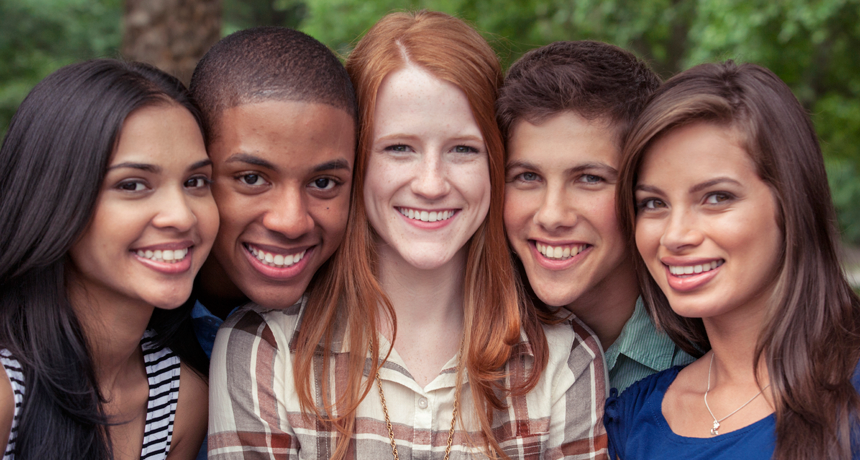

The results of calling our API to preserve privacy would be:

- http://127.0.0.1:8000/?factor=10&url=https://www.sciencenewsforstudents.org/wp-content/uploads/2019/11/860_main_beauty.png

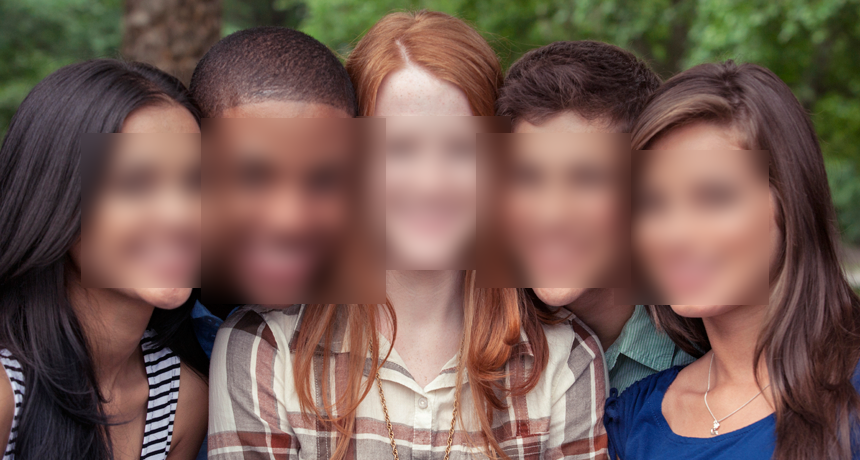

- http://127.0.0.1:8000/?factor=25&url=https://www.sciencenewsforstudents.org/wp-content/uploads/2019/11/860_main_beauty.png


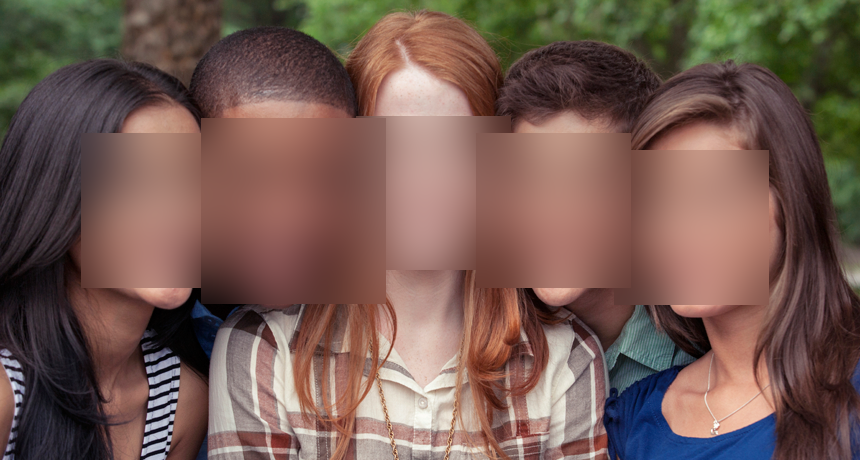